## Pipeline

1. Import libraries 
2. Load data from file
3. Load Stopwords
4. Timestamp filter
5. Search Keyword filter
6. Pre-processing
    - Removing symbols/links
    - Removing stopwords
    - Removing duplicates
    - Lemmatization
7. TF-IDF Vectorization
8. Clustering
    - Elbow curve & Silhouette score
    - Making clusters
    - Top 5 tweets in each cluster
9. Word Cloud
10. LDA

## Importing libraries

In [43]:
import stanza
import urduhack

import pandas as pd
import re
import numpy as np
from urduhack import normalize
from urduhack.normalization import normalize_characters
from urduhack.preprocessing import normalize_whitespace
from urduhack.preprocessing import remove_punctuation
from urduhack.preprocessing import replace_urls
from urduhack.preprocessing import replace_emails
from urduhack.preprocessing import replace_numbers
from urduhack.preprocessing import remove_english_alphabets
from urduhack.normalization import remove_diacritics

from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as mtp    
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize as sklearn_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

from wordcloud import WordCloud
from bidi.algorithm import get_display
from arabic_reshaper import ArabicReshaper

from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import string
import warnings
warnings.filterwarnings('ignore')

## Loading Data & Stopwords

In [44]:
df = pd.read_csv('tweets.csv',encoding='utf-8',error_bad_lines=False)

In [45]:
del df["Unnamed: 0"]
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%a %b %d %H:%M:%S +0000 %Y')

In [46]:
# stopwords
stop_word = "نہیں نے ہاں ہر ہم ہمارا ہمارے ہماری ہو ہوا ہوتا ہوتے ہوتی ہوتیں ہوں ہونا ہونگے ہونے ہونی ہوئے ہوئی ہوئیں ہے ہی ہیں والا والوں والے والی وہ وہاں وہی وہیں یا یعنی یہ یہاں یہی یہیں اب ابھی اپنا اپنے اپنی اس اسے اسی اگر ان انہوں انہی انہیں او اور اے ایسا ایسے ایسی ایک آپ آتا آتے آتی آگے آنا آنے آنی آئے آئی آئیں آیا با بڑا بڑے بڑی بعد بعض بلکہ بہت بھی بے پاس پر پہلے پھر تا تاکہ تب تجھ تجھے تک تم تمام تمہارا تمہارے تمھارے تمہاری تمہیں تمھیں تھا تھے تھی تھیں تو تیری تیرے جا جاتا جاتی جاتے جاتی جانے جانی جاؤ جائے جائیں جب جس جن جنہوں جنہیں جو جیسا جیسے جیسی جیسوں چاہیئے چلا چاہے چونکہ حالانکہ دو دونوں دوں دے دی دیا دیں دیے دیتا دیتے دیتی دینا دینے دینی دیئے ڈالا ڈالنا ڈالنے ڈالنی ڈالے ڈالی ذرا رکھا رکھتا رکھتے رکھتی رکھنا رکھنے رکھے رکھی رہ رہا رہتا رہتے رہتی رہنا رہنے رہنی رہو رہے رہی رہیں زیادہ سا سامنے سب سکتا سو سے سی شاید صرف طرح طرف عین کا کبھی کچھ کہہ کر کرتا کرتے کرتی کرنا کرنے کرو کروں کرے کریں کس کسے کسی کہ کہا کہے کو کون کوئی کے کی کیا کیسے کیوں کیونکہ کیے کئے گا گویا گے گی گیا گئے گئی لا لاتا لاتے لاتی لانا لانے لانی لایا لائے لائی لگا لگے لگی لگیں لو لے لی لیا لیتا لیتے لیتی لیکن لیں لیے لئے مجھ مجھے مگر میرا میرے میری میں کہاں نا نہ نہایت"

In [47]:
def remove_duplicate_words(string):
        x = string.split()
        x = sorted(set(x), key = x.index)
        return ' '.join(x)

In [48]:
# removing duplicates from stop_words list
stop_word = remove_duplicate_words(stop_word)
stop_word = stop_word.split()

## Timestamp filter

In [49]:
def timestamp_filter(start,end,dft):
    filteredTw = []
    filteredTm = []
    for i in range(0,len(dft)):
        if (dft['timestamp'][i] >= start) & (dft['timestamp'][i] <= end):
            filteredTw.append(dft['tweets'][i])
            filteredTm.append(dft['timestamp'][i])
    filtered = pd.DataFrame()
    if(filteredTm and filteredTw is not None):
        filtered['tweets'] = pd.DataFrame(filteredTw)
        filtered['timestamp'] = pd.DataFrame(filteredTm)
    else:
        print("No values found, returning default")
        return dft
    
#     filtered = dft[(dft['timestamp'] >= start) & (dft['timestamp'] <= end)]
    return filtered

In [50]:
# Applying timestamp filter on original dataset

splitdf = timestamp_filter(pd.Timestamp(2022,4,10,20,9,57),pd.Timestamp(2022,4,10,20,9,59),df)
#splitdf

## Keyword Filter

In [51]:
def keyword_filter(df, keyword):
    filteredTw = []
    filteredTm = []
    for i in range(0,len(df)):
        current_tweet =df['tweets'][i] 
        if (keyword in current_tweet):
            filteredTw.append(df['tweets'][i])
            filteredTm.append(df['timestamp'][i])
    filtered = pd.DataFrame()
    if(filteredTm and filteredTw is not None):
        filtered['tweets'] = pd.DataFrame(filteredTw)
        filtered['timestamp'] = pd.DataFrame(filteredTm)
    else:
        print("No values found, returning default")
        return df    
    return filtered

## Pre-Processing

In [52]:
nlp = stanza.Pipeline(lang='ur', processors='tokenize,lemma')

2022-05-17 10:15:35 INFO: Loading these models for language: ur (Urdu):
| Processor | Package |
-----------------------
| tokenize  | udtb    |
| lemma     | udtb    |

2022-05-17 10:15:35 INFO: Use device: cpu
2022-05-17 10:15:35 INFO: Loading: tokenize
2022-05-17 10:15:35 INFO: Loading: lemma
2022-05-17 10:15:35 INFO: Done loading processors!


In [53]:
def preprocess(word):
#    word = re.sub("\W", " ",word)
#    word = re.sub("[a-zA-Z0-9]","",word)
    #word = normalize_characters(word)
    word = remove_punctuation(word)
    word = normalize_whitespace(word)
    word = replace_urls(word)
    word = replace_emails(word)
    word = remove_diacritics(word)
    word = normalize(word)
    word = replace_numbers(word)
    word = remove_english_alphabets(word)
    #STanza lemmentization normalize
    
    doc = nlp(word)
    a = doc.to_dict()
    if(len(a) != 0):
        a = a[0]
        word = ''
        for i in a:
            if not i['lemma'] in stop_word:
                if(i['id']==(a[-1]['id'])):
                    word=word+i['lemma']
                else:
                    word = word+i['lemma']+' '
    
    return word

In [54]:
# Applying pre-processing on original_dataframe to remove links, symbols, duplicates and stopwords
def preprocess_df(original_df):
    unprocessed_tweets = []
    for i in range(len(original_df.index)):
        tweet = original_df[original_df.columns[0]][i]
        unprocessed_tweets.append(tweet)

    preprocessed_tweets =[]
    for tweet in unprocessed_tweets:
        preprocessed_tweets.append(preprocess(tweet))

    preprocessed_df = pd.DataFrame(preprocessed_tweets,columns = ["tweets"])
    preprocessed_df['timestamp'] = pd.to_datetime(original_df['timestamp'], format='%a %b %d %H:%M:%S +0000 %Y')

    return preprocessed_df

In [55]:
preprocessed_splitdf = preprocess_df(splitdf)
preprocessed_splitdf

,tweets,timestamp
0,آپکی رائے تحریک انصاف اسمبلی مستعفی چاہیے,2022-04-10 20:09:57
1,جگر لالہ ٹھنڈک شبنم دریا دل دہل طوفان لحظہ موم...,2022-04-10 20:09:57
2,شہباز شریف کاغذہ نامزدگی منظور ایف آئ پہلا آرڈ...,2022-04-10 20:09:57
3,عمران خان ووٹر چھوٹا سال سارا ووٹس آج و,2022-04-10 20:09:57
4,غیر جمہوری غیر آئینی طریقہ نکال جمہوری ائینی ط...,2022-04-10 20:09:57
5,پاکستان تاریخ پہلا دفعہ چیف آف آرمی سٹاف شدید ...,2022-04-10 20:09:57
6,راولپنڈی لوگ سڑک پہ چھتہ پاکستان شہر سمیت دنیا...,2022-04-10 20:09:57
7,لوگ باہر لوگ نکل جلسا ملک باہر بغیر لیڈر خود خ...,2022-04-10 20:09:57
8,میڈیا بلیک آوٹ کروا اکھاڑ الٹا مزید نقاب آج جن...,2022-04-10 20:09:57
9,شمع فروزاں آندھی ڈراتا شمع فروزاں پروانہ ہزار ...,2022-04-10 20:09:58


## TF-IDF

In [56]:
def tf_idf_vectorization(dataframe):
    tf_idf_vectorizor = TfidfVectorizer(max_features = 5000)
    tf_idf = tf_idf_vectorizor.fit_transform(dataframe['tweets'][:])
    tf_idf_norm = sklearn_normalize(tf_idf)
    tf_idf_array = tf_idf_norm.toarray()
    #pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names())
    return tf_idf_array, tf_idf_vectorizor

In [57]:
tf_idf_array,tf_idf_vectorizor = tf_idf_vectorization(preprocessed_splitdf)

## Elbow Curve & Silhouette Score

In [58]:
def elbowCurve(tf_idf):
    wcss_list= []  #Initializing the list for the values of WCSS  
  
    #Using for loop for iterations from 1 to 10.  
    for i in range(1, 15):  
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state= 42)  
        kmeans.fit(tf_idf)  
        wcss_list.append(kmeans.inertia_)  
    mtp.plot(range(1, 15), wcss_list)  
    mtp.title('The Elobw Method Graph')  
    mtp.xlabel('Number of clusters(k)')  
    mtp.ylabel('wcss_list')  
    mtp.show()

In [59]:
#finding optimal number of clusters using the elbow method  
#elbowCurve(tf_idf_array)

In [60]:
def silhouetteScore(tf_idf_array, k):
    range_n_clusters = range(2,k)
    silhouette_avg = []
    for i in range_n_clusters:
        kmeans = KMeans(n_clusters=i, random_state= 42)  
        kmeans.fit(tf_idf_array)  
        score = silhouette_score(tf_idf_array, kmeans.labels_, metric='euclidean')
        silhouette_avg.append(score)
        #print(i,'Silhouetter Score: %.3f' % score)    
    silhouette_avg
    """plt.plot(range_n_clusters,silhouette_avg,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()"""
    
    max_value = max(silhouette_avg)
    max_index =silhouette_avg.index(max_value)-2
    #print(max_value,max_index)
    #print(silhouette_avg)
    return max_index

In [61]:
max_score_index = silhouetteScore(tf_idf_array,15)
print(max_score_index)

10


## Clustering 

In [62]:
#k = max_score_index
k = 3
model = KMeans(n_clusters=k)
labels = model.fit(tf_idf_array)

In [63]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizor.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 باہر
 لوگ
 عمران
 خان
 تیز
 اللہ
 ملک
 پاکستان
 آج
 شر
Cluster 1:
 تیرا
 پاکستانی
 بھکاری
 باپ
 درکار
 دروازہ
 دا
 خوشی
 خوش
 خان
Cluster 2:
 میڈیا
 راستہ
 سینڈوچ
 مارکیٹ
 سوشل
 دیکھ
 دنگ
 پسندیدہ
 منگوانا
 لبرٹی


In [64]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmodel = model.fit(Y_sklearn)
predicted_values = model.labels_

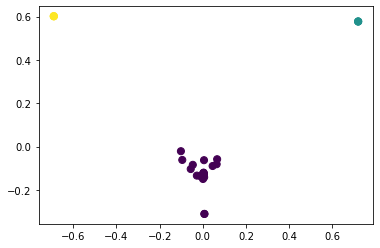

In [65]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

In [66]:
def get_text_of_each_cluster(df, k, labels):
    clusters = []
    preprocessed_clusters = []
    for i in range(k):
        clusters.append([])
        preprocessed_clusters.append([])

    for i,row in df.iterrows():
        clusters[labels[i]].append(row['tweets'])
        preprocessed_clusters[labels[i]].append(preprocess(row['tweets']))
    return [clusters, preprocessed_clusters]

clusters, preprocessed_clusters = get_text_of_each_cluster(splitdf, k,predicted_values)

['RT @SSEHBAI1: لوگ باہر: جیسے لوگ نکل رہے ہیں, جلسے ملک اور باہر بغیر لیڈر کے ہو رہے ہیں، جب خود خان باہرایگا تو کیا حال ہوگا - یہ نام کے شر…',
 'RT @SSEHBAI1: لوگ باہر: جیسے لوگ نکل رہے ہیں, جلسے ملک اور باہر بغیر لیڈر کے ہو رہے ہیں، جب خود خان باہرایگا تو کیا حال ہوگا - یہ نام کے شر…',
 'RT @SSEHBAI1: لوگ باہر: جیسے لوگ نکل رہے ہیں, جلسے ملک اور باہر بغیر لیڈر کے ہو رہے ہیں، جب خود خان باہرایگا تو کیا حال ہوگا - یہ نام کے شر…']

In [67]:
def five_tweets_from_clusters(clusters):
    for i in range(len(clusters)):
        print("Cluster: " + str(i))
        for j in range(min(len(clusters[i]),5)):
            print(clusters[i][j]+'\n')
            
# printing first five tweets from each cluster
#five_tweets_from_clusters(clusters)

## WordClound

In [68]:
def generate_word_cloud(text):
    configuration = {
        "language": "Urdu"
    }
    reshaper = ArabicReshaper(configuration=configuration)

    text = reshaper.reshape(text)
    text = get_display(text)

    word_cloud = WordCloud(collocations = False, background_color = 'white', 
                           scale=5,
                           max_font_size=70,
                           font_path='NotoNaskhArabic-Regular.ttf').generate(text)
    plt.axis("off")
    plt.imshow(word_cloud, interpolation="bilinear")

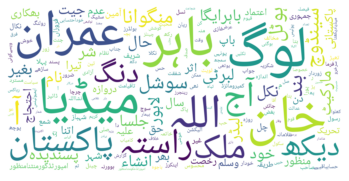

In [69]:
tweets_text = " ".join(tweet for tweet in preprocessed_splitdf['tweets'])
generate_word_cloud(tweets_text)

### Cluster 1 - WordCloud

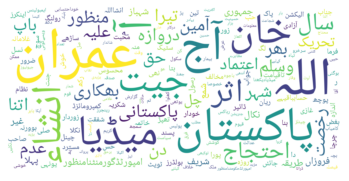

In [70]:
cluster1_text = " ".join(tweet for tweet in preprocessed_clusters[0])
generate_word_cloud(cluster1_text)

### Cluster 2 - WordCloud

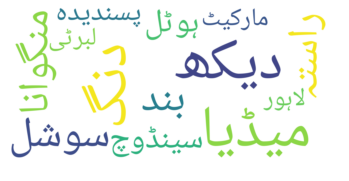

In [71]:
cluster2_text = " ".join(tweet for tweet in preprocessed_clusters[1])
generate_word_cloud(cluster2_text)

### Cluster 3 - WordCloud

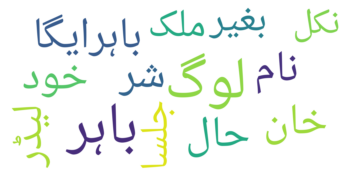

In [72]:
cluster3_text = " ".join(tweet for tweet in preprocessed_clusters[2])
generate_word_cloud(cluster3_text)

## Topic Modeling - Latent Dirichlet Allocation

In [73]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhsin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
tweets_df = preprocessed_splitdf[['tweets']]
#tweets_df = tweets_df[['tweets']]
tweets_df['index'] = tweets_df.index
documents = tweets_df

In [75]:
tweets_df

,tweets,index
0,آپکی رائے تحریک انصاف اسمبلی مستعفی چاہیے,0
1,جگر لالہ ٹھنڈک شبنم دریا دل دہل طوفان لحظہ موم...,1
2,شہباز شریف کاغذہ نامزدگی منظور ایف آئ پہلا آرڈ...,2
3,عمران خان ووٹر چھوٹا سال سارا ووٹس آج و,3
4,غیر جمہوری غیر آئینی طریقہ نکال جمہوری ائینی ط...,4
5,پاکستان تاریخ پہلا دفعہ چیف آف آرمی سٹاف شدید ...,5
6,راولپنڈی لوگ سڑک پہ چھتہ پاکستان شہر سمیت دنیا...,6
7,لوگ باہر لوگ نکل جلسا ملک باہر بغیر لیڈر خود خ...,7
8,میڈیا بلیک آوٹ کروا اکھاڑ الٹا مزید نقاب آج جن...,8
9,شمع فروزاں آندھی ڈراتا شمع فروزاں پروانہ ہزار ...,9


In [76]:
def preprocess_text(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [77]:
processed_docs = documents['tweets'].map(preprocess_text)
processed_docs[:10]

0    [آپکی, رائے, تحریک, انصاف, اسمبلی, مستعفی, چاہیے]
1         [لالہ, ٹھنڈک, شبنم, دریا, طوفان, لحظہ, مومن]
2    [شہباز, شریف, کاغذہ, نامزدگی, منظور, پہلا, آرڈ...
3                     [عمران, ووٹر, چھوٹا, سارا, ووٹس]
4    [جمہوری, آئینی, طریقہ, نکال, جمہوری, ائینی, طر...
5    [پاکستان, تاریخ, پہلا, دفعہ, آرمی, سٹاف, شدید,...
6    [راولپنڈی, چھتہ, پاکستان, سمیت, دنیا, عمران, م...
7             [باہر, جلسا, باہر, بغیر, لیڈر, باہرایگا]
8    [میڈیا, بلیک, کروا, اکھاڑ, الٹا, مزید, نقاب, ج...
9         [فروزاں, آندھی, ڈراتا, فروزاں, پروانہ, ہزار]
Name: tweets, dtype: object

In [78]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 آپکی
1 اسمبلی
2 انصاف
3 تحریک
4 رائے
5 مستعفی
6 چاہیے
7 دریا
8 شبنم
9 طوفان
10 لالہ


In [124]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]